In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import st_dep as st
import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoding_type = 'pos'
model_name = 'rnn'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
vocab_dep = generic.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

In [13]:
emb_dim = 100
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

## ABOUT

In [14]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6744012194020408 	 Validation loss: 0.6599233776836072 	 
  1%|          | 574/57400 [00:10<15:16, 62.04it/s]
Epoch 2 	 Training loss: 0.6220162860815533 	 Validation loss: 0.604662607281895 	 
  2%|▏         | 1148/57400 [00:19<15:25, 60.75it/s]
Epoch 3 	 Training loss: 0.58305870157501 	 Validation loss: 0.574369835651527 	 
  3%|▎         | 1722/57400 [00:29<15:32, 59.73it/s]
Epoch 4 	 Training loss: 0.5568503820522321 	 Validation loss: 0.556406893467499 	 
  4%|▍         | 2296/57400 [00:39<14:53, 61.66it/s]
Epoch 5 	 Training loss: 0.5343532343670881 	 Validation loss: 0.5361010457499552 	 
  5%|▌         | 2870/57400 [00:49<15:04, 60.27it/s]
Epoch 6 	 Training loss: 0.5124284414256491 	 Validation loss: 0.5194895388716358 	 
  6%|▌         | 3444/57400 [00:58<14:31, 61.88it/s]
Epoch 7 	 Training loss: 0.49429177246234973 	 Validation loss: 0.5173820944155677 	 
  7%|▋         | 4018/57400 [01:08<15:32, 57.25it/s]
Epoch 8 	 Training loss: 0.478787734273

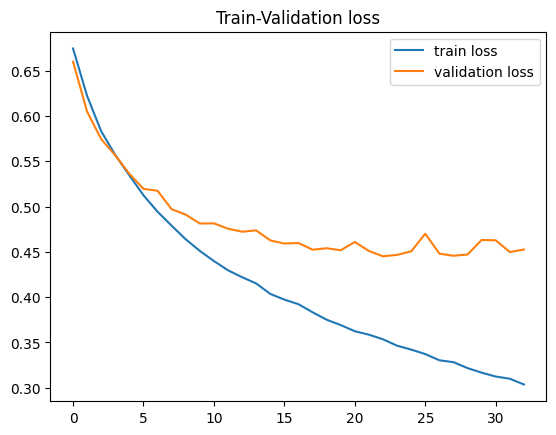

In [15]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_about'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.585, 'male': 0.8697916666666666, 'average': 0.7273958333333332}
precision {'female': 0.823943661971831, 'male': 0.668, 'average': 0.7459718309859156}
f1 {'female': 0.6842105263157894, 'male': 0.755656108597285, 'average': 0.7199333174565372}
accuracy 0.7244897959183674


Evaluación en el conjunto el conjunto to
recall {'female': 0.4304461942257218, 'male': 0.7153284671532847, 'average': 0.5728873306895033}
precision {'female': 0.5836298932384342, 'male': 0.5753424657534246, 'average': 0.5794861794959294}
f1 {'female': 0.4954682779456194, 'male': 0.6377440347071583, 'average': 0.5666061563263889}
accuracy 0.5782828282828283


Evaluación en el conjunto el conjunto as
recall {'female': 0.477088948787062, 'male': 0.7348484848484849, 'average': 0.6059687168177734}
precision {'female': 0.6276595744680851, 'male': 0.6, 'average': 0.6138297872340426}
f1 {'female': 0.5421133231240429, 'male': 0.6606129398410896, 'average': 0.6013

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6737627072409055 	 Validation loss: 0.6578620621713541 	 
  1%|          | 574/57400 [00:09<15:07, 62.62it/s]
Epoch 2 	 Training loss: 0.6258980034743452 	 Validation loss: 0.6157903994544077 	 
  2%|▏         | 1148/57400 [00:19<15:13, 61.61it/s]
Epoch 3 	 Training loss: 0.5863141180746231 	 Validation loss: 0.5820968726934013 	 
  3%|▎         | 1722/57400 [00:29<15:09, 61.25it/s]
Epoch 4 	 Training loss: 0.5569257566945478 	 Validation loss: 0.5605578326572807 	 
  4%|▍         | 2296/57400 [00:39<14:59, 61.23it/s]
Epoch 5 	 Training loss: 0.5309379842742394 	 Validation loss: 0.5548576222637952 	 
  5%|▌         | 2870/57400 [00:49<14:32, 62.51it/s]
Epoch 6 	 Training loss: 0.5097241623372566 	 Validation loss: 0.5252579127327871 	 
  6%|▌         | 3444/57400 [00:59<15:22, 58.46it/s]
Epoch 7 	 Training loss: 0.4910137308599226 	 Validation loss: 0.5128718872191542 	 
  7%|▋         | 4018/57400 [01:09<14:52, 59.82it/s]
Epoch 8 	 Training loss: 0.47568114

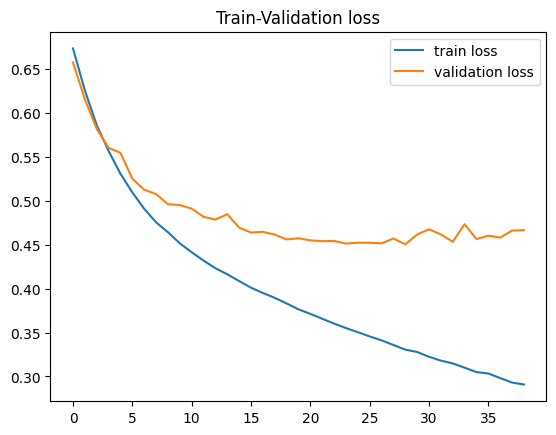

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_about2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.6825, 'male': 0.8072916666666666, 'average': 0.7448958333333333}
precision {'female': 0.7867435158501441, 'male': 0.7093821510297483, 'average': 0.7480628334399462}
f1 {'female': 0.7309236947791166, 'male': 0.7551766138855054, 'average': 0.7430501543323109}
accuracy 0.7436224489795918


Evaluación en el conjunto el conjunto to
recall {'female': 0.5223097112860893, 'male': 0.681265206812652, 'average': 0.6017874590493706}
precision {'female': 0.603030303030303, 'male': 0.6060606060606061, 'average': 0.6045454545454545}
f1 {'female': 0.559774964838256, 'male': 0.6414662084765177, 'average': 0.6006205866573868}
accuracy 0.6047979797979798


Evaluación en el conjunto el conjunto as
recall {'female': 0.5444743935309974, 'male': 0.6565656565656566, 'average': 0.6005200250483269}
precision {'female': 0.5976331360946746, 'male': 0.6060606060606061, 'average': 0.6018468710776403}
f1 {'female': 0.5698166431593795, 'male': 0.630303

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6740028875837758 	 Validation loss: 0.6514736919079797 	 
  1%|          | 574/57400 [00:09<15:51, 59.74it/s]
Epoch 2 	 Training loss: 0.6157920198573468 	 Validation loss: 0.5991689997204279 	 
  2%|▏         | 1148/57400 [00:19<15:06, 62.04it/s]
Epoch 3 	 Training loss: 0.5787372779659278 	 Validation loss: 0.5770572201680328 	 
  3%|▎         | 1722/57400 [00:29<15:14, 60.91it/s]
Epoch 4 	 Training loss: 0.5525506764961867 	 Validation loss: 0.5565651160175518 	 
  4%|▍         | 2296/57400 [00:39<15:16, 60.11it/s]
Epoch 5 	 Training loss: 0.5297802904757057 	 Validation loss: 0.5361298802545515 	 
  5%|▌         | 2870/57400 [00:49<15:07, 60.12it/s]
Epoch 6 	 Training loss: 0.5086946114118922 	 Validation loss: 0.5218327409130031 	 
  6%|▌         | 3444/57400 [00:59<14:30, 62.00it/s]
Epoch 7 	 Training loss: 0.4908937643110129 	 Validation loss: 0.5058748328079612 	 
  7%|▋         | 4018/57400 [01:08<15:20, 57.97it/s]
Epoch 8 	 Training loss: 0.47543254

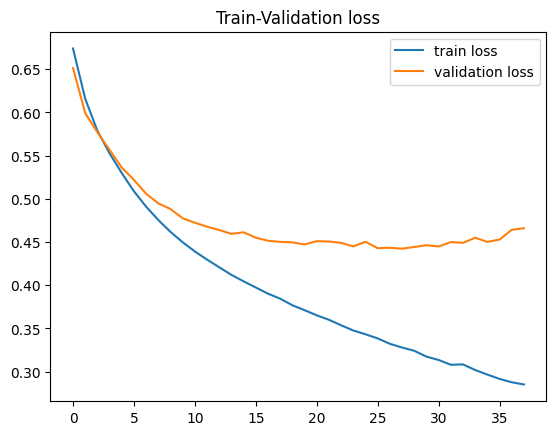

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_about3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.6225, 'male': 0.8333333333333334, 'average': 0.7279166666666668}
precision {'female': 0.7955271565495208, 'male': 0.6794055201698513, 'average': 0.737466338359686}
f1 {'female': 0.6984572230014026, 'male': 0.7485380116959065, 'average': 0.7234976173486545}
accuracy 0.7257653061224489


Evaluación en el conjunto el conjunto to
recall {'female': 0.49343832020997375, 'male': 0.7031630170316302, 'average': 0.598300668620802}
precision {'female': 0.6064516129032258, 'male': 0.5995850622406639, 'average': 0.6030183375719449}
f1 {'female': 0.5441389290882779, 'male': 0.6472564389697648, 'average': 0.5956976840290213}
accuracy 0.6022727272727273


Evaluación en el conjunto el conjunto as
recall {'female': 0.49056603773584906, 'male': 0.6792929292929293, 'average': 0.5849294835143892}
precision {'female': 0.5889967637540453, 'male': 0.5873362445414847, 'average': 0.5881665041477651}
f1 {'female': 0.5352941176470588, 'male': 0.629

In [21]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.7288270297125009
f1 etiqueta male: 0.7531235780595656
f1 etiqueta female:  0.7045304813654362


TO
Resultado global f1: 0.5876414756709324
f1 etiqueta male: 0.6421555607178137
f1 etiqueta female:  0.533127390624051


AS
Resultado global f1: 0.594686105811809
f1 etiqueta male: 0.6402975169801243
f1 etiqueta female:  0.5490746946434938


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.7334027777777777
recall etiqueta male: 0.8368055555555556
recall etiqueta female:  0.63


TO
Resultado global recall: 0.5909918194532253
recall etiqueta male: 0.699918896999189
recall etiqueta female:  0.4820647419072616


AS
Resultado global recall: 0.5971394084601632
recall etiqueta male: 0.6902356902356902
recall etiqueta female:  0.5040431266846361


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.7438336675951825
precision etiqueta male: 0.6855958903998666
precision etiqueta female:  0.8020714447904986



## TO

In [22]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6938044513974871 	 Validation loss: 0.6923654483536542 	 
  1%|          | 574/57400 [00:10<16:40, 56.82it/s]
Epoch 2 	 Training loss: 0.6936533718989701 	 Validation loss: 0.6934203050904355 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:20<16:20, 57.38it/s]
Epoch 3 	 Training loss: 0.693399663170871 	 Validation loss: 0.6925532433946254 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:31<16:00, 57.97it/s]
Epoch 4 	 Training loss: 0.6933453398714498 	 Validation loss: 0.6935648089748317 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:41<16:03, 57.19it/s]
Epoch 5 	 Training loss: 0.6930227735524394 	 Validation loss: 0.6921814841739202 	 
  5%|▌         | 2870/57400 [00:52<15:41, 57.92it/s]
Epoch 6 	 Training loss: 0.692966652664158 	 Validation loss: 0.692382261914722 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [01:02<15:35, 57.68it/s]
Epoch 7 	 Training loss: 0.6928577403365943 	 Validation los

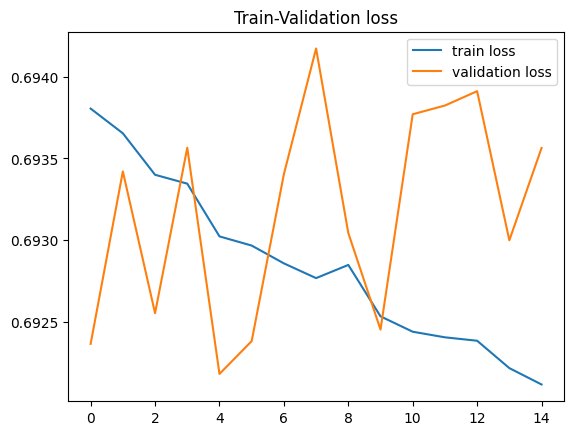

In [23]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_to'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [24]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.6675, 'male': 0.3333333333333333, 'average': 0.5004166666666666}
precision {'female': 0.5105162523900574, 'male': 0.4904214559386973, 'average': 0.5004688541643774}
f1 {'female': 0.5785482123510294, 'male': 0.39689922480620154, 'average': 0.48772371857861546}
accuracy 0.5038265306122449


Evaluación en el conjunto el conjunto to
recall {'female': 0.6824146981627297, 'male': 0.340632603406326, 'average': 0.5115236507845279}
precision {'female': 0.4896421845574388, 'male': 0.5363984674329502, 'average': 0.5130203259951944}
f1 {'female': 0.5701754385964912, 'male': 0.4166666666666667, 'average': 0.493421052631579}
accuracy 0.5050505050505051


Evaluación en el conjunto el conjunto as
recall {'female': 0.7088948787061995, 'male': 0.2474747474747475, 'average': 0.4781848130904735}
precision {'female': 0.46880570409982175, 'male': 0.47572815533980584, 'average': 0.47226692971981377}
f1 {'female': 0.5643776824034334, 'male': 0.

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6937918186395425 	 Validation loss: 0.6949252405409085 	 
  1%|          | 574/57400 [00:10<16:19, 58.04it/s]
Epoch 2 	 Training loss: 0.6933406811557996 	 Validation loss: 0.6928624803737059 	 
  2%|▏         | 1148/57400 [00:20<16:10, 57.97it/s]
Epoch 3 	 Training loss: 0.6933766211989865 	 Validation loss: 0.6944147429223788 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:31<16:25, 56.53it/s]
Epoch 4 	 Training loss: 0.6932250351648297 	 Validation loss: 0.697042456117727 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:41<16:27, 55.82it/s]
Epoch 5 	 Training loss: 0.6929795088876 	 Validation loss: 0.6925004377203473 	 
  5%|▌         | 2870/57400 [00:52<15:39, 58.06it/s]
Epoch 6 	 Training loss: 0.6931141393732941 	 Validation loss: 0.6949348197144977 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [01:02<15:40, 57.37it/s]
Epoch 7 	 Training loss: 0.6929459861554336 	 Validation loss: 0.6933896228418512 	 

2 ep

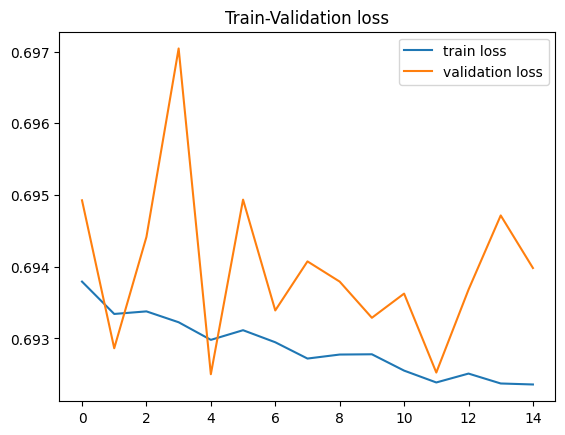

In [25]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_to2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [26]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.66, 'male': 0.3541666666666667, 'average': 0.5070833333333333}
precision {'female': 0.515625, 'male': 0.5, 'average': 0.5078125}
f1 {'female': 0.5789473684210525, 'male': 0.4146341463414634, 'average': 0.496790757381258}
accuracy 0.5102040816326531


Evaluación en el conjunto el conjunto to
recall {'female': 0.7007874015748031, 'male': 0.35523114355231145, 'average': 0.5280092725635572}
precision {'female': 0.5018796992481203, 'male': 0.5615384615384615, 'average': 0.5317090803932909}
f1 {'female': 0.5848849945235488, 'male': 0.43517138599105815, 'average': 0.5100281902573035}
accuracy 0.5214646464646465


Evaluación en el conjunto el conjunto as
recall {'female': 0.6846361185983828, 'male': 0.2777777777777778, 'average': 0.4812069481880803}
precision {'female': 0.4703703703703704, 'male': 0.4845814977973568, 'average': 0.4774759340838636}
f1 {'female': 0.5576289791437979, 'male': 0.3531300160513644, 'average': 0.4553794

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936466082255599 	 Validation loss: 0.6956758185968561 	 
  1%|          | 574/57400 [00:10<16:52, 56.14it/s]
Epoch 2 	 Training loss: 0.6935147337797212 	 Validation loss: 0.6939777752100411 	 
  2%|▏         | 1148/57400 [00:21<16:48, 55.79it/s]
Epoch 3 	 Training loss: 0.6933042675983615 	 Validation loss: 0.6950493283190969 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:31<16:21, 56.70it/s]
Epoch 4 	 Training loss: 0.6931502054792663 	 Validation loss: 0.693465755147449 	 
  4%|▍         | 2296/57400 [00:42<15:48, 58.10it/s]
Epoch 5 	 Training loss: 0.693081874984482 	 Validation loss: 0.6970522878533703 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:52<15:11, 59.84it/s]
Epoch 6 	 Training loss: 0.6930291825055245 	 Validation loss: 0.6933014029163426 	 
  6%|▌         | 3444/57400 [01:02<15:21, 58.57it/s]
Epoch 7 	 Training loss: 0.6928633653951439 	 Validation loss: 0.6929601986529463 	 
  7%|▋         | 4018/57400 [01:

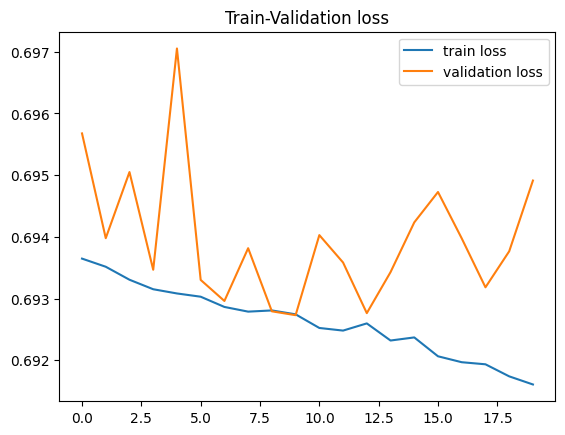

In [27]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_to3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [28]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.3175, 'male': 0.6432291666666666, 'average': 0.4803645833333333}
precision {'female': 0.4810606060606061, 'male': 0.475, 'average': 0.478030303030303}
f1 {'female': 0.3825301204819277, 'male': 0.5464601769911503, 'average': 0.464495148736539}
accuracy 0.4770408163265306


Evaluación en el conjunto el conjunto to
recall {'female': 0.3858267716535433, 'male': 0.6739659367396593, 'average': 0.5298963541966013}
precision {'female': 0.5231316725978647, 'male': 0.5420743639921722, 'average': 0.5326030182950185}
f1 {'female': 0.4441087613293051, 'male': 0.6008676789587852, 'average': 0.5224882201440452}
accuracy 0.5353535353535354


Evaluación en el conjunto el conjunto as
recall {'female': 0.3692722371967655, 'male': 0.6237373737373737, 'average': 0.4965048054670696}
precision {'female': 0.479020979020979, 'male': 0.5135135135135135, 'average': 0.4962672462672463}
f1 {'female': 0.4170471841704718, 'male': 0.5632839224629418, '

In [29]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.4830032082321375
f1 etiqueta male: 0.4526645160462718
f1 etiqueta female:  0.5133419004180032


TO
Resultado global f1: 0.5086458210109759
f1 etiqueta male: 0.48423524387217004
f1 etiqueta female:  0.5330563981497817


AS
Resultado global f1: 0.46350819659680775
f1 etiqueta male: 0.4139984446210478
f1 etiqueta female:  0.5130179485725678


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.4959548611111111
recall etiqueta male: 0.4435763888888889
recall etiqueta female:  0.5483333333333333


TO
Resultado global recall: 0.5231430925148954
recall etiqueta male: 0.4566098945660989
recall etiqueta female:  0.5896762904636921


AS
Resultado global recall: 0.48529885558187447
recall etiqueta male: 0.382996632996633
recall etiqueta female:  0.5876010781671159


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.49543721906489346
precision etiqueta male: 0.4884738186462324
precision etiqueta female:  

## AS

In [30]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6938783235666228 	 Validation loss: 0.6929420737896935 	 
  1%|          | 574/57400 [00:10<16:55, 55.97it/s]
Epoch 2 	 Training loss: 0.6934405457267363 	 Validation loss: 0.694402067338006 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:20<16:00, 58.57it/s]
Epoch 3 	 Training loss: 0.6932391655154344 	 Validation loss: 0.6938918616812108 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:31<16:04, 57.73it/s]
Epoch 4 	 Training loss: 0.692853738310445 	 Validation loss: 0.6913839841293077 	 
  4%|▍         | 2296/57400 [00:41<16:04, 57.15it/s]
Epoch 5 	 Training loss: 0.6930028113961635 	 Validation loss: 0.6945521346593307 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:52<15:23, 59.04it/s]
Epoch 6 	 Training loss: 0.6927608461330161 	 Validation loss: 0.6941872542187318 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [01:02<15:48, 56.88it/s]
Epoch 7 	 Training loss: 0.6923635438967249 	 Validation lo

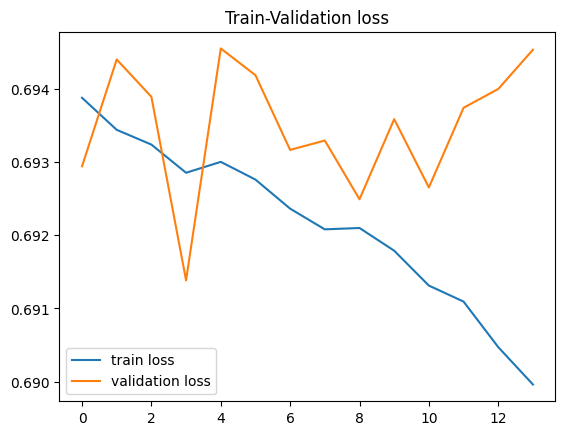

In [31]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_as'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [32]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.5775, 'male': 0.375, 'average': 0.47625}
precision {'female': 0.49044585987261147, 'male': 0.46006389776357826, 'average': 0.47525487881809486}
f1 {'female': 0.5304247990815155, 'male': 0.4131994261119082, 'average': 0.47181211259671185}
accuracy 0.47831632653061223


Evaluación en el conjunto el conjunto to
recall {'female': 0.5721784776902887, 'male': 0.40145985401459855, 'average': 0.48681916585244367}
precision {'female': 0.4698275862068966, 'male': 0.5030487804878049, 'average': 0.4864381833473507}
f1 {'female': 0.5159763313609467, 'male': 0.4465493910690122, 'average': 0.4812628612149794}
accuracy 0.48358585858585856


Evaluación en el conjunto el conjunto as
recall {'female': 0.5929919137466307, 'male': 0.4116161616161616, 'average': 0.5023040376813962}
precision {'female': 0.4856512141280353, 'male': 0.5191082802547771, 'average': 0.5023797471914062}
f1 {'female': 0.5339805825242718, 'male': 0.45915492957746484, 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6937123798742527 	 Validation loss: 0.6923368755033461 	 
  1%|          | 574/57400 [00:10<16:45, 56.52it/s]
Epoch 2 	 Training loss: 0.6932392802595677 	 Validation loss: 0.6923719270754669 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:20<16:23, 57.21it/s]
Epoch 3 	 Training loss: 0.6931857430353398 	 Validation loss: 0.6941210354788828 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:31<16:03, 57.79it/s]
Epoch 4 	 Training loss: 0.6929816397017303 	 Validation loss: 0.6935808870751979 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:41<15:46, 58.24it/s]
Epoch 5 	 Training loss: 0.692830084092941 	 Validation loss: 0.6927040684021125 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:52<15:24, 58.98it/s]
Epoch 6 	 Training loss: 0.6926162709134797 	 Validation loss: 0.6926841311535593 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [01:02<15:21, 58.55it/s]
Epoch 7 	 Training loss: 0.69

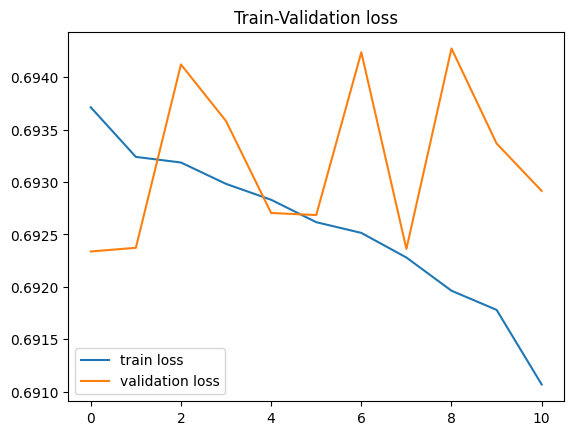

In [33]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_as2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [34]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.75, 'male': 0.2708333333333333, 'average': 0.5104166666666666}
precision {'female': 0.5172413793103449, 'male': 0.5098039215686274, 'average': 0.5135226504394861}
f1 {'female': 0.6122448979591838, 'male': 0.35374149659863946, 'average': 0.48299319727891166}
accuracy 0.5153061224489796


Evaluación en el conjunto el conjunto to
recall {'female': 0.7165354330708661, 'male': 0.30170316301703165, 'average': 0.5091192980439488}
precision {'female': 0.4875, 'male': 0.5344827586206896, 'average': 0.5109913793103448}
f1 {'female': 0.5802337938363443, 'male': 0.385692068429238, 'average': 0.48296293113279115}
accuracy 0.5012626262626263


Evaluación en el conjunto el conjunto as
recall {'female': 0.7304582210242587, 'male': 0.3333333333333333, 'average': 0.531895777178796}
precision {'female': 0.5065420560747663, 'male': 0.5689655172413793, 'average': 0.5377537866580728}
f1 {'female': 0.5982339955849889, 'male': 0.420382165605095

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936426025649812 	 Validation loss: 0.6926557815681069 	 
  1%|          | 574/57400 [00:10<16:10, 58.57it/s]
Epoch 2 	 Training loss: 0.6934544509503899 	 Validation loss: 0.693177515167301 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:20<16:11, 57.87it/s]
Epoch 3 	 Training loss: 0.6929526042439796 	 Validation loss: 0.6919820217762963 	 
  3%|▎         | 1722/57400 [00:31<16:22, 56.69it/s]
Epoch 4 	 Training loss: 0.6931363017093845 	 Validation loss: 0.6930979399357812 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:41<15:49, 58.04it/s]
Epoch 5 	 Training loss: 0.6927107388757248 	 Validation loss: 0.6920533028699584 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:52<16:09, 56.24it/s]
Epoch 6 	 Training loss: 0.6926184559325308 	 Validation loss: 0.6927734239626739 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [01:02<15:44, 57.11it/s]
Epoch 7 	 Training loss: 0.6925014903321084 	 Validation l

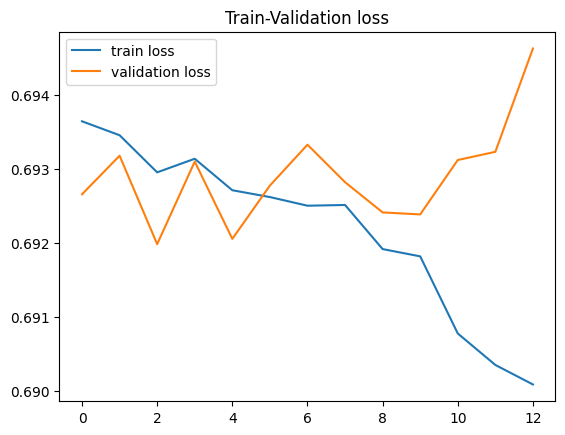

In [35]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_as3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [36]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.9525, 'male': 0.041666666666666664, 'average': 0.4970833333333333}
precision {'female': 0.5086782376502003, 'male': 0.45714285714285713, 'average': 0.4829105473965287}
f1 {'female': 0.6631853785900783, 'male': 0.07637231503579951, 'average': 0.36977884681293893}
accuracy 0.5063775510204082


Evaluación en el conjunto el conjunto to
recall {'female': 0.94750656167979, 'male': 0.0413625304136253, 'average': 0.4944345460467076}
precision {'female': 0.4781456953642384, 'male': 0.4594594594594595, 'average': 0.46880257741184894}
f1 {'female': 0.6355633802816901, 'male': 0.07589285714285714, 'average': 0.3557281187122736}
accuracy 0.4772727272727273


Evaluación en el conjunto el conjunto as
recall {'female': 0.9703504043126685, 'male': 0.04292929292929293, 'average': 0.5066398486209807}
precision {'female': 0.4871447902571042, 'male': 0.6071428571428571, 'average': 0.5471438236999806}
f1 {'female': 0.6486486486486487, 'male':

In [37]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.4415280522295208
f1 etiqueta male: 0.2811044125821157
f1 etiqueta female:  0.6019516918769259


TO
Resultado global f1: 0.4399846370200147
f1 etiqueta male: 0.3027114388803691
f1 etiqueta female:  0.5772578351596603


AS
Resultado global f1: 0.4567648335309588
f1 etiqueta male: 0.3199085914759478
f1 etiqueta female:  0.5936210755859698


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.4945833333333333
recall etiqueta male: 0.22916666666666666
recall etiqueta female:  0.76


TO
Resultado global recall: 0.4967910033143667
recall etiqueta male: 0.24817518248175183
recall etiqueta female:  0.7454068241469816


AS
Resultado global recall: 0.513613221160391
recall etiqueta male: 0.2626262626262626
recall etiqueta female:  0.7646001796945193


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.49056269221803656
precision etiqueta male: 0.4756702254916876
precision etiqueta female:  0.5054551589443